In [7]:
#%%
"""
Created on Thu Nov 30 2018
The Bates Model and implied volatilities obtained with the COS method
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum
import scipy.optimize as optimize

In [8]:
# set i= imaginary number
i   = complex(0.0,1.0)

# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

In [9]:
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)

    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    #assigning i=sqrt(-1)
    i = complex(0.0,1.0)
    x0 = np.log(S0 / K)

    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])
    u = k * np.pi / (b - a);

    # Determine coefficients for Put Prices
    H_k = CallPutCoefficients(CP,a,b,k)
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
    return value

# Determine coefficients for Put Prices
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)

    return H_k

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c

    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0))
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi *
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)

    value = {"chi":chi,"psi":psi }
    return value

In [10]:
# Black-Scholes Call option price
def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

# Implied volatility method
def ImpliedVolatility(CP,marketPrice,K,T,S_0,r):
    # To determine initial volatility we interpolate define a grid for sigma
    # and interpolate on the inverse
    sigmaGrid = np.linspace(0,2,200)
    optPriceGrid = BS_Call_Option_Price(CP,S_0,K,sigmaGrid,T,r)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    #print("Initial volatility = {0}".format(sigmaInitial))

    # Use determined input for the local-search (final tuning)
    func = lambda sigma: np.power(BS_Call_Option_Price(CP,S_0,K,sigma,T,r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-10)
    #print("Final volatility = {0}".format(impliedVol))
    return impliedVol

def ChFBatesModel(r,tau,kappa,gamma,vbar,v0,rho,xiP,muJ,sigmaJ):
    i = complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*\
                               np.exp(-D1(u)*tau)))*(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    AHes= lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*\
        rho*i*u-D1(u)) - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))

    A = lambda u: AHes(u) - xiP * i * u * tau *(np.exp(muJ+0.5*sigmaJ*sigmaJ) - 1.0) + \
            xiP * tau * (np.exp(i*u*muJ - 0.5 * sigmaJ * sigmaJ * u * u) - 1.0)

    # Characteristic function for the Heston's model
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf

In [11]:
def mainCalculation():
    CP  = OptionType.CALL
    S0  = 100.0
    r   = 0.0
    tau = 1.0

    K = np.linspace(40,180,10)
    K = np.array(K).reshape([len(K),1])

    N = 1000
    L = 6

    kappa = 1.2
    gamma = 0.05
    vbar  = 0.05
    rho   = -0.75
    v0    = vbar
    muJ   = 0.0
    sigmaJ= 0.2
    xiP   = 0.1

    # effect of xiP
    plt.figure(1)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    xiPV = [0.01, 0.1, 0.2, 0.3]
    legend = []
    for xiPTemp in xiPV:
       # Evaluate the Bates model
       # Compute ChF for the Bates
       cf = ChFBatesModel(r,tau,kappa,gamma,vbar,v0,rho,xiPTemp,muJ,sigmaJ)

       # The COS method
       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities
       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0)
       legend.append('xiP={0}'.format(xiPTemp))
    plt.legend(legend)

    # effect of muJ
    plt.figure(2)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    muJPV = [-0.5, -0.25, 0, 0.25]
    legend = []
    for muJTemp in muJPV:
       # Evaluate the Bates model
       # Compute ChF for the Bates
       cf = ChFBatesModel(r,tau,kappa,gamma,vbar,v0,rho,xiP,muJTemp,sigmaJ)

       # The COS method
       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities
       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0)
       legend.append('muJ={0}'.format(muJTemp))
    plt.legend(legend)

    # effect of sigmaJ
    plt.figure(3)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    sigmaJV = [0.01, 0.15, 0.2, 0.25]
    legend = []
    for sigmaJTemp in sigmaJV:
       # Evaluate the Bates model
       # Compute ChF for the Bates
       cf = ChFBatesModel(r,tau,kappa,gamma,vbar,v0,rho,xiP,muJ,sigmaJTemp)

       # The COS method
       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities
       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0)
       legend.append('sigmaJ={0}'.format(sigmaJTemp))
    plt.legend(legend)

/var/folders/n8/19ypk1rs6tdbh7vcb43bfl0c0000gn/T/ipykernel_1807/1873458304.py:5: RuntimeWarning: divide by zero encountered in divide
  d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))


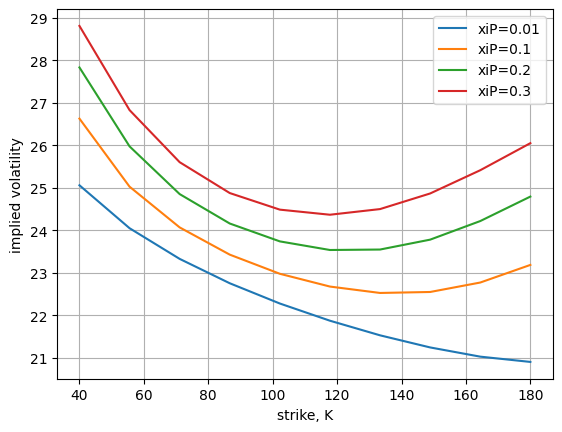

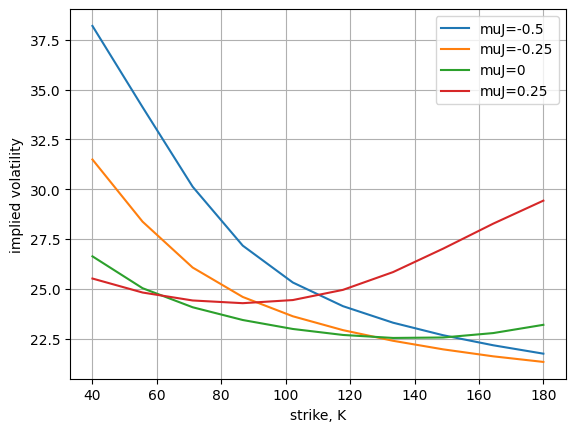

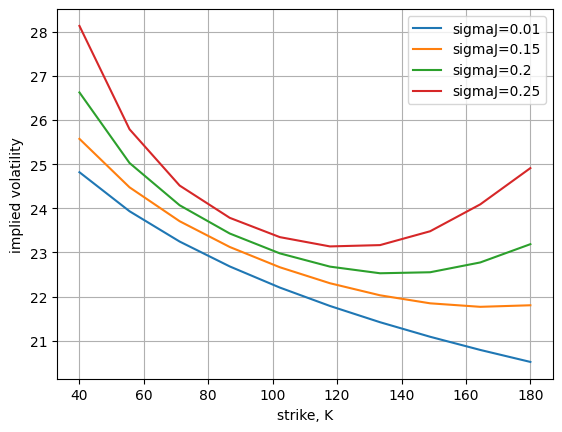

In [12]:
mainCalculation()